# Single-stage optimization prototype
This is the prototype for single-stage optimization using QUADCOIL.
Note that the winding surface's poloidal parameterization is not yet 
robust. 

In [2]:
# Disable pre-allocation to debug memory usage 
import os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [3]:
import jax
jax.devices()
import jax.numpy as jnp
from jax import hessian, grad, jacrev, jvp

In [4]:
# This script generates the plasma surface, winding surface and initial filaments for the 
# force minimization study. Uses the regcoil branch and quadcoil_proto.

import os
# os.environ['XLA_FLAGS'] = '--xla_dump_to=./jax_dump'
# os.environ['JAX_PLATFORMS'] = 'cpu'
import sys
import matplotlib.pyplot as plt
from simsopt.geo import SurfaceRZFourier, plot
from simsopt.field import CurrentPotentialSolve, CurrentPotentialFourier
from simsopt import save, load
from functools import partial
from jax import jit, vmap, jacfwd
from jax.lax import while_loop, fori_loop
import optax
import optax.tree_utils as otu
import time


# Loading QUADCOIL
quadcoil_path = '..'
sys.path.insert(1, quadcoil_path)
# The directory of the c++ code imported in self_force_operator
# must be included separately
sys.path.insert(1, quadcoil_path + '/build')
sys.path.insert(1, quadcoil_path + '/objectives')

from winding_surface_jax import (
    gen_winding_surface_atan,
    winding_surface_field_Bn, 
    cp_make_mn, 
    winding_surface_field_Bn_GI,
    plasma_dofs_to_winding_dofs
)
from surfacerzfourier_jax import SurfaceRZFourierJAX, dof_to_gamma
from jax_solver import eval_quad_scaled, dfdy_from_qcqp
from plotting_utils import plot_coil_Phi_IG
from grid_curvature_operator_jax import grid_curvature_cylindrical
from f_b_and_k_operators_jax import \
    f_B, \
    K2, K_theta, K_helper
from utils import avg_order_of_magnitude


# Loading plasma surface and setting up parameters (replace with your own equilibrium and parameters)

In [5]:
''' --- Loading configs --- '''


# Obtaining a list of all configs
path_plasma_surface = 'plasma_surface/'
list_plasma_surface = os.listdir(path_plasma_surface)
path_vcasing = '2023-09-14.MagneticGradientScalength/vcasing/'
list_vcasing= os.listdir(path_vcasing)
path_bnorm = '2023-09-14.MagneticGradientScalength/bnorm/'
list_bnorm = os.listdir(path_bnorm)
''

''

In [6]:
# Finding a case with name containing the substring. 
# You can change current_name to something you like.
substring='li383'
print('Finding equilibrium containing:', substring)
for i_config, item in enumerate(list_plasma_surface):
    if substring in item:
        break

print(i_config)

current_plasma_surface = list_plasma_surface[i_config]
current_name = current_plasma_surface[:-4]
print('Name:', current_name)



Finding equilibrium containing: li383
31
Name: li383_1.4m_aScaling


In [7]:
''' --- Settings --- '''
n_phi_plasma = 32
n_theta_plasma = 32
# n_phi is per field period
n_phi_winding = 33
n_theta_winding = 33
# In this test file, winding and eval 
# grids must be the same because that's
# how it is in the mosek version. Otherwise
# the comparison will not be valid.
n_phi_eval = n_phi_winding
n_theta_eval = n_theta_winding

# The first constraint is a peak current density constraint that mimics the 
# coil-coil distance constraint in filament optimization. 
# Here we prescribe some arbitrary coil number by multiplying this 
# number to the aspect ratio. The more coils there are, the more accurate the 
# proxy should be
coil_per_aspect_ratio = 4.6503866245115155
mpol_cp = 4
ntor_cp = 4

mpol_winding = 5 # 10
ntor_winding = 5 # 10

mpol_plasma = 5 # 10
ntor_plasma = 5 # 10


In [8]:
from numpy import loadtxt
from jax import config
config.update("jax_enable_x64", False)
''' --- Loading plasma surface --- '''

# Loads the plasma surface into plasma_surface. Replace with your own surface.
surf_dict = jnp.load(path_plasma_surface + current_plasma_surface, allow_pickle=True).item()
plasma_dofs = surf_dict['dofs'].astype(jnp.float32)
stellsym = surf_dict['stellsym']
nfp = surf_dict['nfp']
quadpoints_phi_plasma = jnp.linspace(0, 1/nfp, n_phi_plasma, endpoint=False)
quadpoints_theta_plasma = jnp.linspace(0, 1, n_theta_plasma, endpoint=False)
plasma_surface = SurfaceRZFourier(
    nfp=nfp, 
    stellsym=stellsym, 
    mpol=surf_dict['mpol'], 
    ntor=surf_dict['ntor'], 
    quadpoints_phi=quadpoints_phi_plasma, 
    quadpoints_theta=quadpoints_theta_plasma, 
)
plasma_surface.set_dofs(plasma_dofs)
plasma_surface.change_resolution(mpol_plasma, ntor_plasma)
plasma_dofs = plasma_surface.get_dofs()

''' --- Setting current --- '''


net_poloidal_current_amperes = surf_dict['net_poloidal_current'].astype(jnp.float32)
net_toroidal_current_amperes = 0


''' --- Loading B_plasma --- '''


# Loads the normal magnetic field at the plasma surface
current_vcasing = 'vcasing_' + current_name + '.nc'
current_bnorm = 'bnorm.' + current_name
if current_bnorm in list_bnorm:
    print(current_bnorm, 'found. Loading virtual casing.')
    bnorm_data = loadtxt(path_bnorm+current_bnorm).astype(jnp.float32)
    bnorm_m = jnp.array(bnorm_data[:, 0], dtype=int)
    bnorm_n = jnp.array(bnorm_data[:, 1], dtype=int)
    bnorm_values = bnorm_data[:, 2]
    eval_grid_phi, eval_grid_theta = jnp.meshgrid(
        plasma_surface.quadpoints_phi.astype(jnp.float32), 
        plasma_surface.quadpoints_theta.astype(jnp.float32),
        indexing='ij',
    )
    Bnormal_plasma = jnp.sum(bnorm_values[:, None, None] * jnp.sin(
        bnorm_m[:, None, None] * eval_grid_phi[None, :, :] * jnp.pi * 2
        + bnorm_n[:, None, None] * eval_grid_theta[None, :, :] * jnp.pi * 2
    ), axis=0)
else:
    if current_vcasing in list_vcasing:
        raise TypeError('Equilibrium has no B_norm, but is not a vacuum field! '\
            'This requires virtual_casing to run, which is not functioning '\
            'properly.')
    Bnormal_plasma = jnp.zeros((
        len(plasma_surface.quadpoints_phi),
        len(plasma_surface.quadpoints_theta)
    ))

Bnormal_plasma_flat = Bnormal_plasma.flatten()



bnorm.li383_1.4m_aScaling found. Loading virtual casing.


In [9]:
''' --- Calculating aspect ratio --- '''
plasma_aspect = plasma_surface.aspect_ratio()
total_coil_num_temp = coil_per_aspect_ratio * plasma_aspect
coils_per_half_field_period = round(total_coil_num_temp/2/plasma_surface.nfp)
total_coil_num = coils_per_half_field_period*2*plasma_surface.nfp



''' --- Calculating constraint values --- '''
# Set your min coil coil distance constraint here
coil_coil_distance = (0.5 * plasma_surface.minor_radius()).astype(jnp.float32)
kappa_threshold = (1/(0.2 * plasma_surface.minor_radius())).astype(jnp.float32)
coil_plasma_distance = (plasma_surface.minor_radius() * 2).astype(jnp.float32)



In [10]:
''' Settings '''
current_per_coil = net_poloidal_current_amperes/total_coil_num
max_K2 = (current_per_coil/coil_coil_distance)**2
max_KK = max_K2 * kappa_threshold

# Generating operators in the curvature proxy

In [18]:
@partial(jit, static_argnames=[
    'nfp', 
    'stellsym', 
    'mpol_plasma',
    'ntor_plasma',
    'mpol_winding',
    'ntor_winding',
    'mpol_cp', 
    'ntor_cp', 
    'n_phi_eval_default',
    'n_theta_eval_default',
])
def quadcoil_curvature_problem(
    # Dofs
    plasma_dofs,

    # Equilibrium and related parameters
    Bnormal_plasma,
    net_poloidal_current_amperes, # G
    net_toroidal_current_amperes, # I

    # Coil parameters
    coil_plasma_distance,
    max_K2,
    max_KK,

    # Numerical parameters
    nfp, 
    stellsym, 
    mpol_plasma,
    ntor_plasma,
    quadpoints_phi_plasma,
    quadpoints_theta_plasma,
    mpol_winding=10,
    ntor_winding=10,
    quadpoints_phi_winding=None, # Used to calculate the NESCOIL oeprator.
    quadpoints_theta_winding=None, # Must contail all field periods
    mpol_cp=4, 
    ntor_cp=4, 
    quadpoints_phi_eval=None, # Sample points for the objective
    quadpoints_theta_eval=None, # We recommend including only 1fp.
    n_phi_eval_default=32,
    n_theta_eval_default=32,
):
    # Default quadrature point number
    if quadpoints_phi_winding is None:
        quadpoints_phi_winding = jnp.linspace(0, 1, n_phi_eval_default*nfp, endpoint=False)
        quadpoints_theta_winding = jnp.linspace(0, 1, n_theta_eval_default, endpoint=False)
    if quadpoints_phi_eval is None:
        quadpoints_phi_eval = jnp.linspace(0, 1/nfp, n_phi_eval_default, endpoint=False)
        quadpoints_theta_eval = jnp.linspace(0, 1, n_theta_eval_default, endpoint=False)
    
    
    ndof_cp = 2 * mpol_cp * ntor_cp + mpol_cp + ntor_cp
    if not stellsym:
        ndof_cp *= 2
    # Angle coordinates in a mesh
    # theta_mesh_winding, phi_mesh_winding = jnp.meshgrid(quadpoints_theta_winding, quadpoints_phi_winding)
    # theta_mesh_plasma, phi_mesh_plasma = jnp.meshgrid(quadpoints_theta_plasma, quadpoints_phi_plasma)
    # theta_mesh_eval, phi_mesh_eval = jnp.meshgrid(quadpoints_theta_eval, quadpoints_phi_eval)

    # Flattening constant normal field
    Bnormal_plasma_flat = Bnormal_plasma.flatten()
    plasma_surface_jax = SurfaceRZFourierJAX(
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_plasma, 
        ntor=ntor_plasma, 
        quadpoints_phi=quadpoints_phi_plasma, 
        quadpoints_theta=quadpoints_theta_plasma, 
        dofs=plasma_dofs
    )

    ''' Plasma surface calculations'''
    gammadash1_plasma = plasma_surface_jax.gammadash1()
    gammadash2_plasma = plasma_surface_jax.gammadash2()
    normal_plasma = plasma_surface_jax.normal()

    ''' Generating winding surface '''
    winding_dofs, gamma_plasma = plasma_dofs_to_winding_dofs(
        # Dofs
        plasma_dofs=plasma_dofs,
        # Equilibrium and related parameters
        # Coil parameters
        coil_plasma_distance=coil_plasma_distance,
        # Numerical parameters
        nfp=nfp, 
        stellsym=stellsym, 
        mpol_plasma=mpol_plasma,
        ntor_plasma=ntor_plasma,
        quadpoints_phi_plasma=quadpoints_phi_plasma,
        quadpoints_theta_plasma=quadpoints_theta_plasma,
        mpol_winding=mpol_winding, 
        ntor_winding=ntor_winding,
    )


    ''' Winding surface calculations '''
    winding_surface_jax = SurfaceRZFourierJAX(
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_winding, 
        ntor=ntor_winding, 
        quadpoints_phi=quadpoints_phi_winding, 
        quadpoints_theta=quadpoints_theta_winding, 
        dofs=winding_dofs
    )
    eval_surface_jax = SurfaceRZFourierJAX(
        nfp=nfp, 
        stellsym=stellsym, 
        mpol=mpol_winding, 
        ntor=ntor_winding, 
        quadpoints_phi=quadpoints_phi_eval, 
        quadpoints_theta=quadpoints_theta_eval, 
        dofs=winding_dofs
    )
    # Winding operators
    # Operators
    gamma_winding = winding_surface_jax.gamma()
    gammadash1_winding = winding_surface_jax.gammadash1()
    gammadash2_winding = winding_surface_jax.gammadash2()
    gamma_eval = eval_surface_jax.gamma()
    gammadash1_eval = eval_surface_jax.gammadash1()
    gammadash2_eval = eval_surface_jax.gammadash2()
    gammadash1dash1_eval = eval_surface_jax.gammadash1dash1()
    gammadash1dash2_eval = eval_surface_jax.gammadash1dash2()
    gammadash2dash2_eval = eval_surface_jax.gammadash2dash2()
    # Evaluation quadrature points
    normal_eval = eval_surface_jax.normal()
    # Winding quadrature points (for calculating f_B)
    normal_winding = winding_surface_jax.normal()


    ''' Calculating the NESCOIL (field error) operator '''
    m_cp, n_cp = cp_make_mn(mpol_cp, ntor_cp, stellsym)

    if stellsym:
        ndofs_half = ndof_cp
    else:
        ndofs_half = ndof_cp // 2
    dzeta_plasma = (quadpoints_phi_plasma[1] - quadpoints_phi_plasma[0])
    dtheta_plasma = (quadpoints_theta_plasma[1] - quadpoints_theta_plasma[0])
    dzeta_coil = (quadpoints_phi_winding[1] - quadpoints_phi_winding[0])
    dtheta_coil = (quadpoints_theta_winding[1] - quadpoints_theta_winding[0])

    normal_plasma_flat = normal_plasma.reshape(-1, 3)
    normal_winding_flat = normal_winding.reshape(-1, 3)
    points_plasma_flat = gamma_plasma.reshape(-1, 3)
    points_coil_flat = gamma_winding.reshape(-1, 3)
    gammadash1_winding_flat = gammadash1_winding.reshape(-1, 3)
    gammadash2_winding_flat = gammadash2_winding.reshape(-1, 3)

    gj_unscaled, _ = winding_surface_field_Bn(
        points_plasma_flat, # contig(points_plasma), 
        points_coil_flat, # contig(points_coil), 
        normal_plasma_flat, # contig(normal_plasma), 
        normal_winding_flat, # contig(normal), 
        stellsym, # self.winding_surface.stellsym, 
        jnp.ravel(winding_surface_jax.phi_mesh), # contig(zeta_coil), 
        jnp.ravel(winding_surface_jax.theta_mesh), # contig(theta_coil), 
        ndof_cp, # dummy, but used to keep the function signature the same
        m_cp[:ndofs_half], # contig(self.current_potential.m[:ndofs_half]), 
        n_cp[:ndofs_half], # contig(self.current_potential.n[:ndofs_half]), 
        nfp# self.winding_surface.nfp
    )
    gj = gj_unscaled * jnp.sqrt(dzeta_plasma * dtheta_plasma * dzeta_coil ** 2 * dtheta_coil ** 2)

    normN_plasma = jnp.linalg.norm(normal_plasma, axis=-1)
    B_GI = winding_surface_field_Bn_GI(
        points_plasma_flat, # points_plasma, 
        points_coil_flat, # points_coil, 
        normal_plasma_flat, # normal_plasma,
        jnp.ravel(winding_surface_jax.phi_mesh), # zeta_coil, 
        jnp.ravel(winding_surface_jax.theta_mesh), # theta_coil, 
        net_poloidal_current_amperes, # G
        net_toroidal_current_amperes, # I
        gammadash1_winding_flat, # gammadash1, 
        gammadash2_winding_flat, # gammadash2
    ) * dzeta_coil * dtheta_coil

    normN_plasma = jnp.linalg.norm(normal_plasma_flat, axis=-1)
    b_e = - jnp.sqrt(normN_plasma * dzeta_plasma * dtheta_plasma) * (B_GI + Bnormal_plasma_flat)


    ''' Calculating operators '''
    sign_windowpane = -jnp.sign(net_poloidal_current_amperes)
    A_f_B, b_f_B, c_f_B, B_normal = f_B(
        gj=gj,
        b_e=b_e,
        plasma_normal=normal_plasma,
        nfp=nfp
    )
    A_KK_cyl, b_KK_cyl, c_KK_cyl = grid_curvature_cylindrical(
        gamma=gamma_eval,
        normal=normal_eval,
        gammadash1=gammadash1_eval,
        gammadash2=gammadash2_eval,
        gammadash1dash1=gammadash1dash1_eval,
        gammadash1dash2=gammadash1dash2_eval,
        gammadash2dash2=gammadash2dash2_eval,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=net_toroidal_current_amperes,
        quadpoints_phi=quadpoints_phi_eval,
        quadpoints_theta=quadpoints_theta_eval,
        nfp=nfp, 
        cp_m=m_cp, 
        cp_n=n_cp,
        stellsym=stellsym,
    )
    A_K2, b_K2, c_K2 = K2(
        normal=normal_eval,
        gammadash1=gammadash1_eval,
        gammadash2=gammadash2_eval,
        net_poloidal_current_amperes=net_poloidal_current_amperes,
        net_toroidal_current_amperes=net_toroidal_current_amperes,
        quadpoints_phi=quadpoints_phi_eval,
        quadpoints_theta=quadpoints_theta_eval,
        nfp=nfp, 
        cp_m=m_cp, 
        cp_n=n_cp,
        stellsym=stellsym,
    )
    A_K_theta, b_K_theta, c_K_theta = K_theta(
            net_poloidal_current_amperes,
            quadpoints_phi_eval,
            quadpoints_theta_eval,
            nfp, m_cp, n_cp,
            stellsym,
    )

    ''' Normalization constants '''
    # These are constants used to normalize the operators.
    total_current = jnp.linalg.norm(jnp.array([
        net_poloidal_current_amperes,
        net_toroidal_current_amperes
    ]))
    plasma_r = jnp.linalg.norm(gamma_plasma[:, :, :-1], axis=-1)
    plasma_z = gamma_plasma[:, :, -1]
    minor_radius_z = jnp.average(jnp.max(plasma_z, axis=1) - jnp.min(plasma_z, axis=1))/2
    minor_radius_r = jnp.average(jnp.max(plasma_r, axis=1) - jnp.min(plasma_r, axis=1))/2
    # A minor radius estimate used for normalization
    minor_a_normalization = (minor_radius_z + minor_radius_r)/2
    major_a_normalization = jnp.average(plasma_r)
    # 4 pi^2 Rr 
    surface_area_normalization = 4 * jnp.pi**2 * major_a_normalization * minor_a_normalization
    
    ''' Scaling objectives '''
    current_scale = 1 / total_current
    # scale_f_B = avg_order_of_magnitude(c_f_B)
    # scale_KK_cyl = avg_order_of_magnitude(c_KK_cyl)
    # scale_K2 = avg_order_of_magnitude(c_K2)
    # scale_K_theta = avg_order_of_magnitude(c_K_theta)
    # Has the unit of (mu0/4pi K)^2 l^2 = (1e-7)
    scale_f_B = (1e-14 * max_K2) * surface_area_normalization # avg_order_of_magnitude(c_f_B)
    # Has the unit of A^2/m^3
    scale_KK_cyl = max_KK # avg_order_of_magnitude(c_KK_cyl)
    # Has the unit of A^2/m^2
    scale_K2 = max_K2 # avg_order_of_magnitude(c_K2)
    # Has the unit of A/m
    scale_K_theta = jnp.sqrt(max_K2) # avg_order_of_magnitude(c_K_theta)\n",

    ''' Flattening operators'''
    # Flatten all operators and taking stellarator symmetry into account
    A_K_theta_obj = A_K_theta.reshape((-1, ndof_cp, ndof_cp))
    b_K_theta_obj = b_K_theta.reshape((-1, ndof_cp))
    c_K_theta_obj = c_K_theta.flatten()
    A_K2_obj = A_K2.reshape((-1, ndof_cp, ndof_cp))
    b_K2_obj = b_K2.reshape((-1, ndof_cp))
    c_K2_obj = c_K2.flatten()
    A_KK_cyl_obj = A_KK_cyl.reshape((-1, 3, ndof_cp, ndof_cp))
    b_KK_cyl_obj = b_KK_cyl.reshape((-1, 3, ndof_cp))
    c_KK_cyl_obj = c_KK_cyl.reshape((-1, 3))
    
    if stellsym:
        # Taking just half of the grid points is incorrect, 
        # because our grid DOES NOT INCLUDE ENDPOINTS!
        # This formula isn't exactly the number of unique 
        # gridpoints, but it's an over-estimate of it, 
        # ensuring that no info is lost.
        loop_size_K_l2 = (A_KK_cyl.shape[0] + 1) * (A_KK_cyl.shape[1] + 1) // 2
    else:
        loop_size_K_l2 = A_KK_cyl.shape[0] * A_KK_cyl.shape[1]
    A_K2_obj = A_K2_obj[:loop_size_K_l2]
    b_K2_obj = b_K2_obj[:loop_size_K_l2]
    c_K2_obj = c_K2_obj[:loop_size_K_l2]
    A_KK_cyl_obj = A_KK_cyl_obj[:loop_size_K_l2].reshape((-1, ndof_cp, ndof_cp))
    b_KK_cyl_obj = b_KK_cyl_obj[:loop_size_K_l2].reshape((-1, ndof_cp))
    c_KK_cyl_obj = c_KK_cyl_obj[:loop_size_K_l2].reshape((-1))
    A_K_theta_obj = A_K_theta_obj[:loop_size_K_l2]
    b_K_theta_obj = b_K_theta_obj[:loop_size_K_l2]
    c_K_theta_obj = c_K_theta_obj[:loop_size_K_l2]


    ''' Combining all constraints into 3 big arrays '''
    A_total = jnp.concatenate([
        A_K2_obj/scale_K2, 
        -A_K2_obj/scale_K2, 
        A_KK_cyl_obj/scale_KK_cyl, 
        -A_KK_cyl_obj/scale_KK_cyl, 
        sign_windowpane * A_K_theta_obj/scale_K_theta
    ], axis=0)

    b_total = jnp.concatenate([
        b_K2_obj/scale_K2, 
        -b_K2_obj/scale_K2, 
        b_KK_cyl_obj/scale_KK_cyl, 
        -b_KK_cyl_obj/scale_KK_cyl, 
        sign_windowpane * b_K_theta_obj/scale_K_theta
    ], axis=0)

    c_total = jnp.concatenate([
        c_K2_obj/scale_K2 - max_K2/scale_K2, 
        -c_K2_obj/scale_K2 - max_K2/scale_K2, 
        c_KK_cyl_obj/scale_KK_cyl - max_KK/scale_KK_cyl, 
        -c_KK_cyl_obj/scale_KK_cyl - max_KK/scale_KK_cyl, 
        sign_windowpane * c_K_theta_obj/scale_K_theta
    ], axis=0)

    ndof_cp = 2 * mpol_cp * ntor_cp + mpol_cp + ntor_cp
    if not stellsym:
        ndof_cp *= 2

    return({
        'A_f': A_f_B/scale_f_B, # 
        'b_f': b_f_B/scale_f_B, # 
        'c_f': c_f_B/scale_f_B, # 
        'A_eq': None, # 
        'b_eq': None, # 
        'c_eq': None, # 
        'A_ineq': A_total, # 
        'b_ineq': b_total, # 
        'c_ineq': c_total, # 
        'x_scale': current_scale, # current_scale
        'A_f_B': A_f_B, 
        'b_f_B': b_f_B, 
        'c_f_B': c_f_B,
        'A_KK_cyl': A_KK_cyl, 
        'b_KK_cyl': b_KK_cyl, 
        'c_KK_cyl': c_KK_cyl,
        'A_K2': A_K2, 
        'b_K2': b_K2, 
        'c_K2': c_K2,
        'A_K_theta': A_K_theta, 
        'b_K_theta': b_K_theta, 
        'c_K_theta': c_K_theta,
        'winding_dofs': winding_dofs,
    })

# Setting up a QUADCOIL study
A QUADCOIL study should
1. Take plasma dof
2. Generate coefs and objectives
3. Call implicit differentiation 

In [21]:
@partial(jit, static_argnames=[
    'init_mode', 
])
def quadcoil_study(
    plasma_dofs, 
    init_mode='zero', 
    x_init=None,
    tol_outer=1e-5,
    ftol_inner=1e-5,
    xtol_inner=1e-5,
    gtol_inner=1e-5,
):
    gen_dict = lambda y: quadcoil_curvature_problem(
        # Dofs
        plasma_dofs=y,
    
        # Equilibrium and related parameters
        Bnormal_plasma=Bnormal_plasma,
        net_poloidal_current_amperes=net_poloidal_current_amperes, # G
        net_toroidal_current_amperes=net_toroidal_current_amperes, # I
    
        # Coil parameters
        coil_plasma_distance=coil_plasma_distance,
        max_K2=max_K2,
        max_KK=max_KK,
        
        # Numerical parameters
        nfp=nfp, 
        stellsym=stellsym, 
        mpol_plasma=mpol_plasma,
        ntor_plasma=ntor_plasma,
        quadpoints_phi_plasma=quadpoints_phi_plasma,
        quadpoints_theta_plasma=quadpoints_theta_plasma,
        mpol_winding=mpol_winding,
        ntor_winding=ntor_winding,
        mpol_cp=mpol_cp, 
        ntor_cp=ntor_cp, 
        n_phi_eval_default=n_phi_winding, # Was 32
        n_theta_eval_default=n_theta_winding, # Was 32
    )
    # Keys:
    # 'A_f', 'b_f', 'c_f',
    # 'A_eq', 'b_eq', 'c_eq',
    # 'A_ineq', 'b_ineq', 'c_ineq',
    # 'current_scale',
    # 'A_f_B', 'b_f_B', 'c_f_B',
    # 'A_KK_cyl', 'b_KK_cyl', 'c_KK_cyl',
    # 'A_K2', 'b_K2', 'c_K2',
    # 'A_K_theta', 'b_K_theta', 'c_K_theta',
    def y_to_qcqp_coefs(y):
        dict = gen_dict(y)
        return(
            dict['A_f'], 
            dict['b_f'], 
            dict['c_f'],
            dict['A_eq'], 
            dict['b_eq'], 
            dict['c_eq'],
            dict['A_ineq'], 
            dict['b_ineq'], 
            dict['c_ineq'], 
            dict['x_scale']
        )
    def f_B(x, y):
        dict = gen_dict(y)
        return eval_quad_scaled(x, dict['A_f_B'], dict['b_f_B'], dict['c_f_B'], 1)
    # all default tolerances are 1e-7.
    quadcoil_sln, value_and_grad_list, solve_results = dfdy_from_qcqp(
        y_to_qcqp_coefs=y_to_qcqp_coefs,
        f_metric_list=[f_B],
        y_params=plasma_dofs,
        init_mode=init_mode, 
        x_init=x_init,
        tol_outer=tol_outer,
        ftol_inner=ftol_inner,
        xtol_inner=xtol_inner,
        gtol_inner=gtol_inner,
    )
    return quadcoil_sln, value_and_grad_list, solve_results


In [22]:
time1 = time.time()
quadcoil_sln, metric_list, solve_results = quadcoil_study(
    plasma_dofs,
    tol_outer=1e-8,
    ftol_inner=1e-8,
    xtol_inner=1e-8,
    gtol_inner=1e-8,
)
time2 = time.time()
print('Compile time', time2-time1, '(s)')

Compile time 10.636005163192749 (s)


In [23]:
jnp.argmax(jnp.abs(plasma_dofs))

Array(0, dtype=int32)

In [24]:
solve_results.keys()

dict_keys(['c_k', 'conv', 'current_niter', 'f_k', 'lam_k', 'mu_k', 'x_k'])

In [25]:
import numpy as np

In [ ]:
# Testing gradient on a straight line
ind1 = 0
# Number of scan points
n1 = 200
delta_y1_arr = np.linspace(-1, 1, n1) * 1e-1
time_list = []
val_arr = np.zeros(n1)
dfdy1_arr = np.zeros(n1)
y1_arr = np.zeros(n1)
n_iter_list = []
c_k_list = []
plasma_dofs_new = plasma_dofs.copy()
x_init = quadcoil_sln
for i in range(n1):
    plasma_dofs_new[ind1] = plasma_dofs[ind1] + delta_y1_arr[i]
    time1 = time.time()
    x_init, metric_list, results = quadcoil_study(
        plasma_dofs_new,
        tol_outer=1e-8,
        ftol_inner=1e-8,
        xtol_inner=1e-8,
        gtol_inner=1e-8,
    )
    val_arr[i] = metric_list[0][0]
    n_iter_list.append(results['current_niter'])
    c_k_list.append(results['c_k'])
    y1_arr[i] = plasma_dofs[ind1] + delta_y1_arr[i]
    dfdy1_arr[i] = metric_list[0][1][ind1]
    time2 = time.time()
    time_list.append(time2-time1)
    # print('i', i, 'time:', time2-time1, '(s)')

In [ ]:
plt.plot(y1_arr, c_k_list)
plt.xlabel('Plasma dof['+ str(ind1) +']')
plt.ylabel('Field error $f_B$')

In [ ]:
plt.plot(y1_arr, val_arr)
plt.xlabel('Plasma dof['+ str(ind1) +']')
plt.ylabel('Field error $f_B$')

In [ ]:
plt.plot(y1_arr, jnp.gradient(val_arr, y1_arr[1]-y1_arr[0]), label = 'np.gradient')
plt.plot(y1_arr, dfdy1_arr, label='QUADCOIL')
plt.xlabel('Plasma dof['+ str(ind1) +']')
plt.ylabel('Gradient of $f_B$')
plt.legend()

In [62]:
# index of plasma dof to scan
ind1 = 0
ind2 = 1
# Number of scan points
n1 = 20
n2 = 20
y1_arr = jnp.linspace(-1, 1, n1) * 1e-3
y2_arr = jnp.linspace(-1, 1, n2) * 1e-3
time_list = []
val_arr = jnp.zeros((n1, n2))
dfdy1_arr = jnp.zeros((n1, n2))
dfdy2_arr = jnp.zeros((n1, n2))
for i in range(n1):
    print('i', i)
    for j in range(n2):
        plasma_dofs_new = jnp.array(plasma_dofs)
        plasma_dofs_new = plasma_dofs_new.at[ind1].set(
            plasma_dofs[ind1] + y1_arr[i]
        )
        plasma_dofs_new = plasma_dofs_new.at[ind2].set(
            plasma_dofs[ind2] + y2_arr[j]
        )
        time1 = time.time()
        quadcoil_sln, metric_list = quadcoil_study(plasma_dofs)
        val_arr = val_arr.at[i, j].set(metric_list[0][0])
        dfdy1_arr = dfdy1_arr.at[i, j].set(metric_list[0][1][ind1])
        dfdy2_arr = dfdy2_arr.at[i, j].set(metric_list[0][1][ind2])
        time2 = time.time()
        time_list.append(time2-time1)

i 0
i 1


KeyboardInterrupt: 

In [ ]:
# init_mode='zero' # or 'unconstrained'
# tol_outer=1e-7 # was 1e-5
# ftol_inner=1e-7
# xtol_inner=1e-7
# gtol_inner=1e-7
# max_iter_inner=1500
# max_iter_outer=25
# run_opt=run_opt_lbfgs
# lam_init=None
# mu_init=None
# c_init=0.1
# c_growth_rate=1.1

In [ ]:
raise NotImplementedError('Stop here')

# Comparing with MOSEK sln

In [44]:
from operator_helper import A_b_c_to_block_operator
quadpoints_phi_winding = jnp.linspace(0, 1, n_phi_winding*nfp, endpoint=False)
quadpoints_theta_winding = jnp.linspace(0, 1, n_theta_winding, endpoint=False)
''' Generating winding surface '''
winding_dofs, gamma_plasma = plasma_dofs_to_winding_dofs(
    # Dofs
    plasma_dofs,
    # Equilibrium and related parameters
    # Coil parameters
    coil_plasma_distance,
    # Numerical parameters
    nfp, 
    stellsym, 
    mpol_plasma,
    ntor_plasma,
    quadpoints_phi_plasma,
    quadpoints_theta_plasma,
    mpol_winding=mpol_winding,
    ntor_winding=ntor_winding,
)
winding_surface = SurfaceRZFourier(
    nfp=nfp, 
    stellsym=stellsym, 
    mpol=mpol_winding, 
    ntor=ntor_winding, 
    quadpoints_phi=quadpoints_phi_winding, 
    quadpoints_theta=quadpoints_theta_winding, 
)
winding_surface.set_dofs(winding_dofs)
cp = CurrentPotentialFourier(
    winding_surface=winding_surface, 
    mpol=mpol_cp, ntor=ntor_cp,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0,
    quadpoints_phi=winding_surface.quadpoints_phi,
    quadpoints_theta=winding_surface.quadpoints_theta,
    stellsym=winding_surface.stellsym
)

Bnormal_plasma_flat = Bnormal_plasma.flatten()

cpst = CurrentPotentialSolve(
    cp=cp, 
    plasma_surface=plasma_surface,
    Bnormal_plasma=Bnormal_plasma_flat,
)

optimized_phi_mn, f_B_nescoil, _ = cpst.solve_tikhonov(lam=0)


/home/lankef/code/simsopt/src/simsopt/field/currentpotentialsolve.py:76: UserWarning: Beware: the f_B (also called chi^2_B) computed from the CurrentPotentialSolve class will be slightly different than the f_B computed using SquaredFlux with the BiotSavart law implemented in WindingSurfaceField. This is because the optimization formulation and the full BiotSavart calculation are discretized in different ways. This disagreement will worsen at low regularization, but improve with higher resolution on the plasma and coil surfaces. 
  warnings.warn(


In [45]:
A_f_B, b_f_B, c_f_B, B_normal = f_B(
    gj=cpst.gj,
    b_e=cpst.b_e,
    plasma_normal=plasma_surface.normal(),
    nfp=cp.nfp
)
A_KK_cyl, b_KK_cyl, c_KK_cyl = grid_curvature_cylindrical(
    gamma=winding_surface.gamma(),
    normal=winding_surface.normal(),
    gammadash1=winding_surface.gammadash1(),
    gammadash2=winding_surface.gammadash2(),
    gammadash1dash1=winding_surface.gammadash1dash1(),
    gammadash1dash2=winding_surface.gammadash1dash2(),
    gammadash2dash2=winding_surface.gammadash2dash2(),
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    quadpoints_phi=cp.quadpoints_phi,
    quadpoints_theta=cp.quadpoints_theta,
    nfp=cp.nfp, 
    cp_m=cp.m, 
    cp_n=cp.n,
    stellsym=cp.stellsym,
)
A_KK_cyl = A_KK_cyl[:A_KK_cyl.shape[0]//cp.nfp]
b_KK_cyl = b_KK_cyl[:b_KK_cyl.shape[0]//cp.nfp]
c_KK_cyl = c_KK_cyl[:c_KK_cyl.shape[0]//cp.nfp]

A_K2, b_K2, c_K2 = K2(
    normal=winding_surface.normal(),
    gammadash1=winding_surface.gammadash1(),
    gammadash2=winding_surface.gammadash2(),
    net_poloidal_current_amperes=cp.net_poloidal_current_amperes,
    net_toroidal_current_amperes=cp.net_toroidal_current_amperes,
    quadpoints_phi=cp.quadpoints_phi,
    quadpoints_theta=cp.quadpoints_theta,
    nfp=winding_surface.nfp, 
    cp_m=cp.m, 
    cp_n=cp.n,
    stellsym=winding_surface.stellsym,
)

A_K2 = A_K2[:A_K2.shape[0]//cp.nfp]
b_K2 = b_K2[:b_K2.shape[0]//cp.nfp]
c_K2 = c_K2[:c_K2.shape[0]//cp.nfp]

A_K_theta, b_K_theta, c_K_theta = K_theta(
        cp.net_poloidal_current_amperes,
        cp.quadpoints_phi,
        cp.quadpoints_theta,
        cp.nfp, cp.m, cp.n,
        cp.stellsym,
)
A_K_theta = A_K_theta[:A_K_theta.shape[0]//cp.nfp]
b_K_theta = b_K_theta[:b_K_theta.shape[0]//cp.nfp]
c_K_theta = c_K_theta[:c_K_theta.shape[0]//cp.nfp]

scale_f_B = avg_order_of_magnitude(c_f_B)
scale_KK_cyl = avg_order_of_magnitude(c_KK_cyl)
scale_K2 = avg_order_of_magnitude(c_K2)
scale_K_theta = avg_order_of_magnitude(c_K_theta)

In [46]:
current_scale = 1/avg_order_of_magnitude(optimized_phi_mn)

In [ ]:
''' --- Preparing QUADCOIL operators --- '''
import cvxpy_utils

''' Defining unknown '''
n_dof = len(cp.get_dofs())
cvxpy_X, constraints_X = cvxpy_utils.cvxpy_create_X(n_dof)
''' No windowpane '''
(
    constraints_no_windowpane, 
    K_theta_operator, 
    K_theta_scale
) = cvxpy_utils.cvxpy_no_windowpane(cp, current_scale, cvxpy_X)
''' K constraint set '''
AK_l2_operator_raw, AK_l2_scale = A_b_c_to_block_operator(
    A=A_K2, b=b_K2, c=c_K2, 
    current_scale=current_scale,
    normalize=True
)

AKK_operator_raw, AKK_scale = A_b_c_to_block_operator(
    A=A_KK_cyl, b=b_KK_cyl, c=c_KK_cyl, 
    current_scale=current_scale,
    normalize=True
)
# Reshaping
AK_l2_operator = AK_l2_operator_raw.reshape([-1] + list(AK_l2_operator_raw.shape[-2:]))
AKK_operator = AKK_operator_raw.reshape([-1] + list(AKK_operator_raw.shape[-2:]))

In [ ]:

''' Defining unknown '''
n_dof = len(cp.get_dofs())
cvxpy_X, constraints_X = cvxpy_utils.cvxpy_create_X(n_dof)
''' f_B '''
f_B_x_operator_scaled, f_B_scale = A_b_c_to_block_operator(
    A=A_f_B, b=b_f_B, c=c_f_B, 
    current_scale=current_scale,
    normalize=True
)
''' No windowpane '''
(
    constraints_no_windowpane, 
    K_theta_operator, 
    K_theta_scale
) = cvxpy_utils.cvxpy_no_windowpane(cp, current_scale, cvxpy_X)
''' K constraint set '''
AK_l2_operator_raw, AK_l2_scale = A_b_c_to_block_operator(
    A=A_K2, b=b_K2, c=c_K2, 
    current_scale=current_scale,
    normalize=True
)

AKK_operator_raw, AKK_scale = A_b_c_to_block_operator(
    A=A_KK_cyl, b=b_KK_cyl, c=c_KK_cyl, 
    current_scale=current_scale,
    normalize=True
)
# Reshaping
AK_l2_operator = AK_l2_operator_raw.reshape([-1] + list(AK_l2_operator_raw.shape[-2:]))
AKK_operator = AKK_operator_raw.reshape([-1] + list(AKK_operator_raw.shape[-2:]))

In [ ]:
import cvxpy

''' Solving with MOSEK '''
constraints_K_sq_max = []
if cp.stellsym:
    loop_size_K_l2 = AK_l2_operator.shape[0]//2
else:
    loop_size_K_l2 = AK_l2_operator.shape[0]
for i in range(loop_size_K_l2):
    constraints_K_sq_max.append(cvxpy.trace(AK_l2_operator[i, :, :] @ cvxpy_X) <= max_K2/AK_l2_scale)
''' K dot nabla K L1 and Linf constraint set '''
K_dot_nabla_K_comp_scaled_flat = AKK_operator.reshape((
    -1, 3, AKK_operator.shape[-2], AKK_operator.shape[-1]
))
constraints_kdotnablak, p = cvxpy_utils.cvxpy_create_Linf_from_array(
    K_dot_nabla_K_comp_scaled_flat, 
    cvxpy_X, 
    cp.stellsym
)
constraints_kdotnablak_limit = [
    p <= max_KK/AKK_scale
]

In [47]:

try:
    mosek_sln = jnp.load('mosek_sln.npy')
except:
    print("CVXPY+MOSEK sln not available. Calculating from scratch.") 
    import mosek
    cvxpy_K_sq_max = cvxpy.Problem(
        cvxpy.Minimize(cvxpy.trace(f_B_x_operator_scaled @ cvxpy_X)), 
        (
            constraints_X 
            + constraints_kdotnablak
            + constraints_kdotnablak_limit
            + constraints_no_windowpane
            + constraints_K_sq_max
        )
    )
    cvxpy_K_sq_max.solve(
        solver='MOSEK',
        verbose=True
    )
    eigenvals, eigenvecs = jnp.linalg.eig(cvxpy_X.value)
    mosek_sln = cvxpy_X.value[-1, :-1]/current_scale
    solve_time = cvxpy_K_sq_max.solver_stats.solve_time
    jnp.save('mosek_sln.npy', mosek_sln)
    print('CVXPY Time =', solve_time, '(s)')

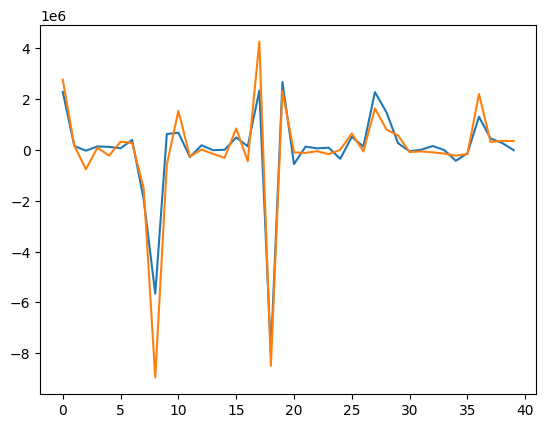

In [49]:
plt.plot(quadcoil_sln, label='quadcoil sln')
plt.plot(mosek_sln, label='mosek sln')

In [50]:
K_theta_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_K_theta,
    b_K_theta, 
    c_K_theta, 
    current_scale
)
f_B_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_f_B,
    b_f_B, 
    c_f_B, 
    current_scale
)
KK_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_KK_cyl,
    b_KK_cyl, 
    c_KK_cyl, 
    current_scale
)
K2_eval = lambda x:eval_quad_scaled(
    x*current_scale, 
    A_K2,
    b_K2, 
    c_K2, 
    current_scale
)


def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

print('MOSEK min K theta', format_e(jnp.min(K_theta_eval(mosek_sln))), 'K theta max', format_e(jnp.max(K_theta_eval(mosek_sln))))
print('Aug   min K theta', format_e(jnp.min(K_theta_eval(quadcoil_sln))), 'K theta max', format_e(jnp.max(K_theta_eval(mosek_sln))))

print('MOSEK max K2', format_e(jnp.max(K2_eval(mosek_sln))), 'K2 max', format_e(max_K2))
print('Aug   max K2', format_e(jnp.max(K2_eval(quadcoil_sln))), 'K2 max', format_e(max_K2))

print('MOSEK KK comp', format_e(jnp.max(jnp.abs(KK_eval(mosek_sln)))), 'KK max', format_e(max_KK))
print('Aug   KK comp', format_e(jnp.max(jnp.abs(KK_eval(quadcoil_sln)))), 'KK max', format_e(max_KK))

print('Mosek f_B', format_e(f_B_eval(mosek_sln)))
print('Optax f_B', format_e(f_B_eval(quadcoil_sln)))

MOSEK min K theta -1.6E+01 K theta max 7.404621E+08
Aug   min K theta -1.4064E+05 K theta max 7.404621E+08
MOSEK max K2 2.345111E+14 K2 max 2.216574E+14
Aug   max K2 2.377639E+14 K2 max 2.216574E+14
MOSEK KK comp 9.4332E+13 KK max 6.502996E+14
Aug   KK comp 9.830617E+13 KK max 6.502996E+14
Mosek f_B 2.214756E+02
Optax f_B 2.000702E+02
